# QComp - Coding Session #3: Trotterization

This is the third part of a series of lab sessions to implement and analyze the HHL algorithm.

* In Coding Session #1, we implemented QPE
* In Coding Session #2, we implemented HHL
* In this coding session, we will analyze different strategy for implementing the gate $e^{iA}$, and its powers.

This coding session is for practice, there is nothing to hand out.

First, make sure libraries are installed (you can uncomment those if needed)

In [1]:
! python -m pip install matplotlib sympy
! python -m pip install qiskit qiskit-aer

  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.4 MB/s  0:00:02 eta 0:00:01


Now, some libraries to load (nothing to modify here)

In [2]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from math import pi, gcd
from qiskit import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator
from scipy import optimize
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Small library for pretty-printing (nothing to do)

In [3]:
def nat2bl(pad,n):
    if n == 0: r = [0 for i in range(pad)]
    elif n % 2 == 1: r = nat2bl(pad-1,(n-1)//2); r.append(1)
    else: r = nat2bl(pad-1,n//2); r.append(0)
    return r

def bl2nat(s):
    if len(s) == 0: return 0
    else: a = s.pop(); return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0: return ""
    else: a = l.pop(); return (bl2bs(l) + str(a))

def nat2bs(pad,i): return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)): l.append(int(s[i]))
    return l

def bs2nat(s): return bl2nat(bs2bl(s))


def processOneState(st): # Length = power of 2
        s = list(st)
        if len(s) == 2: return {'0' : s[0], '1' : s[1]}
        else:
            a0 = processOneState(s[:len(s)//2])
            a1 = processOneState(s[len(s)//2:])
            r = {}
            for k in a0: r['0' + k] = a0[k]
            for k in a1: r['1' + k] = a1[k]
            return r

def printOneState(d, keys=None): # get a dict as per processStates output
    isThereMore = True
    if keys == None:
        keys = d.keys()
        isThereMore = False
    for k in sorted(keys):
        if k not in d:
            print(f"Error: {k} not valid. Maybe the size of the bitstring is invalid?")
            isThereMore = False
            break
        im = d[k].imag
        re = d[k].real
        if abs(im) >= 0.001 or abs(re) >= 0.001:
            print("% .5f + % .5fj |%s>" % (re,im,k))
    if isThereMore: print(" ... (there might be more hidden terms)")

def printFinalRes(result, keys=None):
    printOneState(processOneState(list(np.asarray(result))), keys)

def runStateVector(qc, keys=None):
    simulator = StatevectorSimulator(statevector_parallel_threshold=6)
    job = simulator.run(qc.decompose(reps=12), memory=True)
    job_result = job.result()
    result = job_result.results[0].to_dict()['data']['statevector']
    printFinalRes(result, keys)

def runStateVectorSeveralTimes(qc, howmany):
    qc.save_statevector(label = 'collect', pershot = True)
    simulator = StatevectorSimulator()
    job = simulator.run(qc.decompose(reps=12), memory=True, shots=howmany)
    result = job.result()
    memory = result.data(0)['memory']
    collect = result.data(0)['collect']
    r = {}
    for i in range(len(collect)):
        r[str(collect[i])] = (0, collect[i])
    for i in range(len(collect)):
        n, v = r[str(collect[i])]
        r[str(collect[i])] = (n+1, v)
    for k in r:
        i, v = r[k]
        print(f"With {i} occurences:")
        printFinalRes(v)

def plotDistrib(d):
    sorted_items = sorted(d.items())
    keys = [k for k, _ in sorted_items]
    values = [v for _, v in sorted_items]
    plt.figure()
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.show()

def getSample(qc,howmany):
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=12), shots=howmany)
    res = dict(job.result().get_counts(qc))
    return res

def plotSample(qc,howmany):
    d = getSample(qc,howmany)
    ld = len(list(d.keys())[0])
    for i in range(2 ** ld):
        s = nat2bs(ld,i)
        if s not in d: d[s] = 0
    plotDistrib(d)

def flipEndian(matrix):
    lm = len(matrix)
    n = int(np.log2(lm))
    if lm != 2 ** n:
        raise Exception("dimension error")
    res = [[0 for i in range(lm)] for j in range(lm)]
    for i in range(lm):
        ii = bs2nat(nat2bs(n,i)[::-1])
        for j in range(lm):
            jj = bs2nat(nat2bs(n,j)[::-1])
            res[i][j] = matrix[ii][jj]
    return np.array(res)



# 0 - Some Background

## 0.1 - Computing (and Showing) Unitary Matrices from a Circuit

QisKit can be convinced to show the matrix corresponding to a circuit, as followed.

In [10]:

q = QuantumRegister(2, name="q")
qc = QuantumCircuit(q)

qc.cx(q[0],q[1])


matrix_cnot = np.array(Operator.from_circuit(qc))

matrix_cnot



array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])


You might notice that we asked for a CNOT gate... Qiskit is by default
placing the least significant bit on the left. I wrote for you a small
wrapper function flipping its position, when needed.

In [5]:
flipEndian(matrix_cnot)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

## 0.2 - Estimating the distance between two matrices.

Let us add a very small perturbation to the circuit `qc`.

In [11]:
qc.rx(0.1, q[0])

matrix_cnot_perturb = np.array(Operator.from_circuit(qc))

matrix_cnot_perturb

array([[0.99875026+0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        -0.04997917j],
       [0.        -0.04997917j, 0.        +0.j        ,
        0.        +0.j        , 0.99875026+0.j        ],
       [0.        +0.j        , 0.        -0.04997917j,
        0.99875026+0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.99875026+0.j        ,
        0.        -0.04997917j, 0.        +0.j        ]])


The library `scipy` contains a method to estimate the spectral norm of a
matrix. We can then estimate the error between `matrix_cnot` and
`matrix_cnot_perturb` as follows.

In [12]:

linalg.interpolative.estimate_spectral_norm(matrix_cnot - matrix_cnot_perturb)



0.049994791829424665

This matrix norm is the one that we shall be using in the rest of this lab session.

## 0.3 - Circuit decomposition

QisKit comes with an automated process to decompose circuits into
elementary gates. It is using a completely generic procedure, akin to
what can be found in Section 4.3 of the lecture notes.

We show here how to use it to decompose the matrix that we call $A_2$:

In [13]:

A2 = np.array([[1,2,0,0],
               [2,1,2,0],
               [0,2,1,2],
               [0,0,2,1]])

t = 9/16

U = UnitaryGate(Operator(linalg.expm(1j*t*A2)), label="U")

q = QuantumRegister(2, name="q")
qc = QuantumCircuit(q)
qc.append(U,q)

# We ask for a decomposition with CNOTs, Rx and Rz gates.
qc_elementary = transpile(qc, basis_gates=['cx', 'rx', 'rz'])

print(qc_elementary.draw())

d = dict(qc_elementary.count_ops())
print("each gate appears as follows:", d)
r = 0
for i in d:
    r += d[i]
print("total number of gates:", r)



global phase: 5.2749
     ┌─────────┐   ┌─────────┐  ┌─────────────┐     ┌─────────────┐»
q_0: ┤ Rz(π/2) ├───┤ Rx(π/2) ├──┤ Rz(-1.2236) ├──■──┤ Rx(-2.2626) ├»
     ├─────────┴┐┌─┴─────────┴─┐└─────────────┘┌─┴─┐└┬────────────┤»
q_1: ┤ Rz(-π/2) ├┤ Rx(-1.7229) ├───────────────┤ X ├─┤ Rz(2.0329) ├»
     └──────────┘└─────────────┘               └───┘ └────────────┘»
«     ┌────────────┐                     ┌─────────┐  ┌──────────┐
«q_0: ┤ Rz(1.2236) ├────────────────■────┤ Rx(π/2) ├──┤ Rz(-π/2) ├
«     ├────────────┤┌────────────┐┌─┴─┐┌─┴─────────┴─┐├─────────┬┘
«q_1: ┤ Rx(1.6561) ├┤ Rz(-3.004) ├┤ X ├┤ Rx(0.15207) ├┤ Rz(π/2) ├─
«     └────────────┘└────────────┘└───┘└─────────────┘└─────────┘ 
each gate appears as follows: {'rz': 8, 'rx': 6, 'cx': 2}
total number of gates: 16


# 1 - Small example to warm up

Consider the matrix

$$B = \left(\begin{matrix}
1 & 3 \\ 3 & -1
\end{matrix}\right)$$

## 1.1 - **TODO** Implementing Trotterization

Use Trotterization to realize a circuit implementing

$$
e^{i\frac{1}{3}B}
$$

What error do you reach with 100 iterations?

In [14]:

B = np.array([[1,3],[3,-1]])
# B = 3X + Z
t = 1/3

exact = linalg.expm(1j * t * B)

d = {}

def trotterB(p): # p is the number of iterations
    q = QuantumRegister(1, name="q")
    qc = QuantumCircuit(q)
    for i in range(p):
        #RZ(o) = exp(-i*o*Z/2)
        qc.rz(-2*t/p, q[0])
        qc.rx(-6*t/p, q[0])

    
    return qc

approx = np.array(Operator.from_circuit(trotterB(100)))
    
error = linalg.interpolative.estimate_spectral_norm(exact - approx)

print("The error is:", error)



The error is: 0.002749467629215726


After 100 iterations: The error is: 0.002749467629215726

## 1.2 - Behavior of the Error w.r.t. Iterations Count

In class, we discussed the fact that the error between $e^{itM}$ and
its Trotter implementation $U^M_{t,n}$ using $n$ iterations hs the
following asymptotic behavior:

$$
|\!| e^{itM} - U^{M}_{t,n} |\!| \simeq O\left(\frac{t^2}{n}\right)
$$


**TODO**

In the next cell, plot the function $n \mapsto 1/f(n)$, where $f(n)$ is
$$
f(n) = |\!| e^{i\frac1{3}B} - U^B_{\frac1{2},n} |\!|
$$

You can use $n=10, 20, \ldots 200$.

How many iterations would be needed to reach an error of $10^{-8}$ ?

**Hint** The function `np.polyfit([x1,x2,x3],[y1,y2,y3],1)` gives the coefficients of the best linear approximation going through the points `(x1,y1)`, `(x2,y2)` and `(x3,y3)`. It works for any number of points.

**Hint**  If `keys = [1,2,3]` and `values=[1,4,9]`, then `plt.plot(keys, values)` followed by `plt.show()` will draw the points `(1,1)`, `(2,4)` and `(3,9)`.

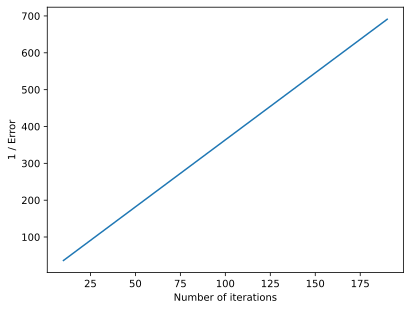

[ 3.63716074 -0.01137371]
To obtain an error of 10^-8, we need 27493973 iterations


In [23]:

exact = linalg.expm(1j * t * B)
keys = [i for i in range(10, 200, 10)]
values = []

for i in keys:
    approx = np.array(Operator.from_circuit(trotterB(i)))
    values
    
    error = linalg.interpolative.estimate_spectral_norm(exact - approx)
    values.append(1/error)

plt.plot(keys, values)
plt.xlabel("Number of iterations")
plt.ylabel("1 / Error")
plt.show()
error = 1
#On obtient une droite car l'erreur est proportionnelle à 1/Nombre d'itérations
# Pour savoir le nombre d'itérations nécessaire pour obtenir une erreur donnée, il suffit d'utiliser une régression linéaire
droite = np.polyfit(keys, values, 1)
print(droite)
print("To obtain an error of 10^-8, we need", int(1/(droite[0]*10**(-8))), "iterations")

## 2 - More involved matrices

### 2.1 - The easy case

Consider the matrix $C$, of size $4\times4$:

$$
C = \left(
\begin{matrix}
1 & 2 & 0 & 2\\
2 & 1 & 2 & 0\\
0 & 2 & 1 & 2\\
2 & 0 & 2 & 1
\end{matrix}
\right)
$$

**TODO**

1. Generate a decomposition as a linear combination of Pauli strings.
2. Using this linear combination, write a decomposition for $e^{i\frac12 C}$ as an **exact** circuit.
3. Verify that it work by computing the error with the exact matrix.

**Hint**

Global phase can be added to a circuit by simply doing `qc.global_phase = [something]`

In [42]:

C = np.array([[1,2,0,2],
              [2,1,2,0],
              [0,2,1,2],
              [2,0,2,1]])

q = QuantumRegister(2, name="q")
qc = QuantumCircuit(q)

t = 1/2

qc.global_phase = t


qc.rx(-4*t, q[1])
# qc.h(q[1])
# qc.cx(q[0], q[1])
# qc.rz(-4*t, q[1])
# qc.cx(q[0], q[1])
# qc.h(q[1])


qc.h(q)
qc.cx(q[0], q[1])
qc.rz(-4*t, q[1])
qc.cx(q[0], q[1])
qc.h(q)

# q2 = QuantumRegister(2, name="q2")
# qc2 = QuantumCircuit(q2)
# U = UnitaryGate(Operator(linalg.expm(1j*t*C)), label="U")
# qc2.append(U,q2)
# qc = transpile(qc2, basis_gates=['ry', 'rx', 'rz', 'cx'])

print(qc.draw())

approx = flipEndian(np.array(Operator.from_circuit(qc)))

exact = linalg.expm(1j * t * C)

diff = linalg.interpolative.estimate_spectral_norm(exact - approx)

print("Error is", diff)



global phase: 0.5
       ┌───┐                            ┌───┐
q_0: ──┤ H ├──────────■──────────────■──┤ H ├
     ┌─┴───┴──┐┌───┐┌─┴─┐┌────────┐┌─┴─┐├───┤
q_1: ┤ Rx(-2) ├┤ H ├┤ X ├┤ Rz(-2) ├┤ X ├┤ H ├
     └────────┘└───┘└───┘└────────┘└───┘└───┘
Error is 5.762896794153104e-16


### 2.2 - A small change

Let us remove the extremal $2$ to reach the matrix

$$
A_2 = \left(
\begin{matrix}
1 & 2 & 0 & 0\\
2 & 1 & 2 & 0\\
0 & 2 & 1 & 2\\
0 & 0 & 2 & 1
\end{matrix}
\right)
$$

**TODO**

1. Write $A_2$ as a linear decomposition of Pauli strings. You will need the fact that

$$
Y\otimes Y = \left(
\begin{matrix}
 0 & 0 & 0 &-1 \\
 0 & 0 & 1 & 0 \\
 0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0
\end{matrix}
\right)
$$

2. Use Trotterization to approximate $e^{i\frac12A_2}$
3. How many iteration steps are needed for reaching a precision of $10^{-3}$?

In [44]:

A2 = np.array([[1,2,0,0],
               [2,1,2,0],
               [0,2,1,2],
               [0,0,2,1]])

N = 10000
t = 1/2

def trotterA2(N): # N iteration steps
    q = QuantumRegister(2, name="q")
    qc = QuantumCircuit(q)
    for i in range(N):
        qc.rx(-4*t/N, q[1])
        qc.h(q)
        qc.cx(q[0], q[1])
        qc.rz(-4*t/N, q[1])
        qc.cx(q[0], q[1])
        qc.h(q)

        qc.s(q)
        qc.h(q)
        qc.cx(q[0], q[1])
        qc.rz(-4*t/N, q[1])
        qc.cx(q[0], q[1])
        qc.h(q)
        qc.sdg(q)
        
    return qc

qc = trotterA2(N)
approx = flipEndian(np.array(Operator.from_circuit(qc)))

exact = linalg.expm(1j * t * A2)

diff = linalg.interpolative.estimate_spectral_norm(exact - approx)

print("Error is", diff)


Error is 1.3077520590560308


## 3 - Going larger

We shall now consider a family of matrices of the shape of $A_2$: the
matrices $A_n$ are defined inductively following the following pattern.

$A_1$ of size $2\times2$:
$$
\left(
\begin{matrix}
1 & 2\\
2 & 1
\end{matrix}
\right)
$$


$A_2$ of size $4\times4$:

$$
\left(
\begin{matrix}
1 & 2 & 0 & 0\\
2 & 1 & 2 & 0\\
0 & 2 & 1 & 2\\
0 & 0 & 2 & 1
\end{matrix}
\right)
$$


$A_3$ is of size $8\times8$:

$$
\left(
\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 0\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
0 & 0 & 0 & 0  &  0 & 0 & 2 & 1
\end{matrix}
\right)
$$

$A_4$ of size $16\times16$:

$$
\left(
\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 2 & 1  &  2 & 0 & 0 & 0  &  0 & 0 & 0 & 0
\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 2  &  1 & 2 & 0 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 0 & 0  &  0 & 0 & 2 & 1\\
\end{matrix}
\right)
$$


### 3.1 - Coding the family $A_n$

**TODO** Fill in the following code so that `A(n)` is the matrix $A_n$.

In [ ]:

def An(n):
    a = 1
    b = 2
    
    N = 2 ** n
    
    A = [[0 for i in range(N)] for j in range(N)]

    # TODO
    # TODO
    # TODO
    
    return np.array(A)

print(An(2))
print(An(3))
print(An(4))


### 3.2 - Pauli decompositions of $A_n$

We want to generate a decomposition of $A_n$ as a sum of Pauli
strings. We could look for an algebraic formulation by deriving an
inductive formula, but I propose instead to reformulate the problem
into a linear system of equations. If this is very crude and could be
done better, it somehow works for matrices over a handful of qubits,
enough for this lab session.

The following code shows one way to do it (nothing to do until the TODO below).

In [ ]:

pauli = ["i", "x", "y", "z"]

pmat = {"i" : np.matrix([[1,0],[0,1]]),
        "x" : np.matrix([[0,1],[1,0]]),
        "y" : np.matrix([[0,-1j],[1j,0]]),
        "z" : np.matrix([[1,0],[0,-1]])}

def tens(a,b):
     na = len(a)
     nb = len(b)

     c = [[0 for i in range(na*nb)] for j in range(na*nb)]

     for ia in range(na):
          for ja in range(na):
               for ib in range(nb):
                    for jb in range(nb):
                         c[ia*nb + ib][ja*nb + jb] = a[ia,ja]*b[ib,jb]

     return np.matrix(c)

def ntens(a):
    res = np.matrix([[1]])
    for k in range(len(a)): res = tens(res, a[k])
    return res

def paulistring_m(a):
    return ntens([pmat[p] for p in a])

print("Y tensor Y")
print(paulistring_m(["y","y"]))

print("Z tensor X")
print(paulistring_m(["z","x"]))

print("I tensor Z tensor X")
print(paulistring_m(["i", "z","x"]))



In [ ]:

def paulistrings(n):
    res = list(itertools.product(pauli, repeat=n))
    return [list(item) for item in res]

print("All Pauli strings of size 3:")
print(paulistrings(3))



In [ ]:

import sympy as sym

def decomposeAsPauliStrings(A):
    n = int(np.log2(len(A)))
    
    ps = paulistrings(n)
    
    pvar = [sym.Symbol("".join(ps[k])) for k in range(len(ps))]
    
    res = 0
    for k in range(len(ps)):
        res = res + pvar[k] * paulistring_m(ps[k])

    eqs = [item for sublist in (res - A).tolist() for item in sublist]
        
    solx = sym.solve(eqs, pvar)
    sol = {}
    for k in solx:
        if solx[k] != 0.0:
            sol[k] = solx[k]
    return sol

In [ ]:
# Let us decompose C

print(decomposeAsPauliStrings(C))




**TODO**

1. For $n=2,3,4$, count how many Pauli strings are in the decomposition of $A_n$.
2. What is your guess on the behavior of the number of terms in the decomposition for $n$, in general?
3. Can you give a bound on the number of gates in the Trotterization of $A_n$, parameterized by $n$ and `p`, the number of steps in the iteration?
4. If you had enough time and memory and asked Qiskit to give you an exact decomposition for $A_n$ in elementary gates, can you estimate the size of the circuit as a function of $n$?
5. Consider 1000 iterations: For which $n$ would Trotterization win over exact synthesis? 

In [ ]:

# TODO
# TODO
# TODO